<a href="https://colab.research.google.com/github/Pri1235/DA-analysis/blob/main/Fine_tuning_LayoutLMv2ForSequenceClassification_on_RVL_CDIP_(using_LayoutLMv2Processor).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done


In [3]:
!pip install -q datasets

In [4]:
! sudo apt install tesseract-ocr
! pip install -q pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [79]:
from google.colab import drive
drive.mount('/train_data')

Drive already mounted at /train_data; to attempt to forcibly remount, call drive.mount("/train_data", force_remount=True).


In [36]:
import requests, zipfile, io

def download_data():
    url = "/train_test_data/MyDrive/train_data"
    # r = requests.get(url)
    # z = zipfile.ZipFile(io.BytesIO(r.content))
    # z.extractall()

# download_data()

In [7]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


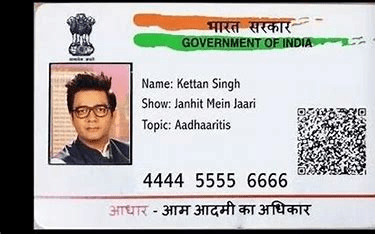

In [38]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/train_data/MyDrive/train_data/Aadhar_Card/ac.png")
image = image.convert("RGB")
image

In [39]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'TT Name: Kettan Singh ‘Show: Janhit Mein Jari Topic: Aadhaaritis 4444 5555 6666 = HTT TGA ar HTT'

In [40]:
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

/usr/local/lib/python3.8/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [41]:
encoded_inputs = processor(image, return_tensors="pt")

In [42]:
for k,v in encoded_inputs.items():
  print(k, v.shape)

input_ids torch.Size([1, 37])
bbox torch.Size([1, 37, 4])
token_type_ids torch.Size([1, 37])
attention_mask torch.Size([1, 37])
image torch.Size([1, 3, 224, 224])


In [43]:
processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())

'[CLS] tt name : kettan singh ‘ show : janhit mein jari topic : aadhaaritis 4444 5555 6666 = htt tga ar htt [SEP]'

In [44]:
import pandas as pd
import os

dataset_path = "/train_data/MyDrive/train_data"
labels = [label for label in os.listdir(dataset_path)]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'Aadhar_Card': 0,
 'Driving_license': 1,
 'Pan_Card': 2,
 'Passport': 3,
 'Photographs': 4,
 'Utility_bills': 5,
 'Voters_ID': 6}

In [48]:
# images = []
# labels = []

# for label_folder, _, file_names in os.walk(dataset_path):
#   if label_folder != dataset_path:
#     label = label_folder[40:]
#     # print("label",label)
#     for _, _, image_names in os.walk(label_folder):
#       relative_image_names = []
#       # print(image_names)
#       for image_file in image_names:
#         relative_image_names.append(dataset_path + "/" + label + "/" + image_file)
#       images.extend(relative_image_names)
#     labels=pd.DataFrame({'image_path':relative_image_names})
#     # labels["label"]=labels
#   # print(label)
#     # labels=label_folder[40:]

# data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
# data.tail()
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = label_folder[31:]
    for _, _, image_names in os.walk(label_folder):
      relative_image_names = []
      for image_file in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image_file)
      images.extend(relative_image_names)
      labels.extend([label] * len (relative_image_names)) 

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label
0,/train_data/MyDrive/train_data/Aadhar_Card/ac.png,Aadhar_Card
1,/train_data/MyDrive/train_data/Driving_license...,Driving_license
2,/train_data/MyDrive/train_data/Pan_Card/pc (1)...,Pan_Card
3,/train_data/MyDrive/train_data/Passport/ps (1)...,Passport
4,/train_data/MyDrive/train_data/Photographs/pg ...,Photographs


In [49]:
from datasets import Dataset 

# read dataframe as HuggingFace Datasets object
dataset = Dataset.from_pandas(data)

In [50]:
dataset

Dataset({
    features: ['image_path', 'label'],
    num_rows: 7
})

In [51]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

def preprocess_data(examples):
  # take a batch of images
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  # for path in examples['image_path']:
    # print(path)
  
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  
  # add labels
  encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]

  return encoded_inputs

encoded_dataset = dataset.map(preprocess_data, remove_columns=dataset.column_names, features=features, 
                              batched=True, batch_size=2)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [52]:
encoded_dataset.set_format(type="torch", device="cuda")

In [99]:
import torch

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4)
batch = next(iter(dataloader))

In [100]:
for k,v in batch.items():
  print(k, v.shape)

image torch.Size([4, 3, 224, 224])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels torch.Size([4])


In [101]:
processor.tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] tt name : kettan singh ‘ show : janhit mein jari topic : aadhaaritis 4444 5555 6666 = htt tga ar htt [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [108]:
temp = processor.tokenizer.decode(batch['input_ids'][0])
temp=temp.split( )
for i in range(len(temp)):
  if temp[i]=='name':
    print(temp[i+2],temp[i+3])
  
# print(processor.tokenizer.decode(batch['input_ids'][0].tolist()))

kettan singh


In [56]:
id2label[batch['labels'][0].item()]

'Aadhar_Card'

In [57]:
from transformers import LayoutLMv2ForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", 
                                                            num_labels=len(labels))
model.to(device)

Downloading:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.19.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.11.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.21.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv1.norm.num_batches_tra

LayoutLMv2ForSequenceClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [58]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 10
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in tqdm(dataloader):
      # forward pass
      outputs = model(**batch)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == batch['labels']).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 1.483606179555257
Training accuracy: 14.285715103149414
Epoch: 1


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 1.2598262627919514
Training accuracy: 28.571430206298828
Epoch: 2


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 1.099887212117513
Training accuracy: 57.142860412597656
Epoch: 3


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.9629383484522501
Training accuracy: 71.42857360839844
Epoch: 4


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.7761186162630717
Training accuracy: 85.71428680419922
Epoch: 5


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.6180916031201681
Training accuracy: 100.00000762939453
Epoch: 6


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.517992357412974
Training accuracy: 100.00000762939453
Epoch: 7


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.42944929003715515
Training accuracy: 100.00000762939453
Epoch: 8


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.30088284611701965
Training accuracy: 100.00000762939453
Epoch: 9


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.2524472077687581
Training accuracy: 100.00000762939453


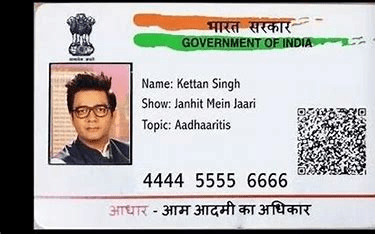

In [59]:
image

In [64]:
# prepare image for the model
encoded_inputs = processor(image, return_tensors="pt")

# make sure all keys of encoded_inputs are on the same device as the model
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(model.device)

# forward pass
outputs = model(**encoded_inputs)

The model outputs `logits` of shape (batch_size, num_labels):

In [65]:
logits = outputs.logits
print(logits.shape)

torch.Size([1, 7])


In [66]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

Predicted class: Passport


In [63]:
image = Image.open("/train_data/MyDrive/content/training_data/d/Passport/ps (1).png")
image = image.convert("RGB")

In [72]:
pip install python-docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 84.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184505 sha256=d58e81420e19466c4805f21d0307bdee1238781e97d03b92df0ef9c626684fcd
  Stored in directory: /root/.cache/pip/wheels/32/b8/b2/c4c2b95765e615fe139b0b17b5ea7c0e1b6519b0a9ec8fb34d
Successfully built python-docx


In [87]:
import os
import cv2
with open("/testing.pdf", "rb") as file:
    pdf = file.read()

# os.mkdir("/content/test")
img_counter = 0
pointer = 0
while True:
    pointer = pdf.find(b"stream", pointer)
    if pointer < 0:
        break

    x = pdf.find(b"\xff\xd8", pointer)
    if x < 0:
        pointer = pointer + 1
        continue
    else:
        extension = "jpg"

    limit = pdf.find(b"endstream", pointer)
    if limit < 0:
        break

    y = pdf.find(b"\xff\xd9", pointer, limit) + 2

    pointer = limit + 9
    if y < 2:
        continue        
    
    img = pdf[x:y]

  
#add a new directory call 'test' to save the extracted images for prediction
    img_counter = img_counter + 1
    with open(os.path.join("/content/test","img_" + str(img_counter) + "." + extension), "wb") as jpgfile:
       jpgfile.write(img)
      #  cv2.imwrite("/content/test",jpgfile.write(img))
    
   

In [ ]:
import csv
f = open('output_detect.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow()

# close the file
f.close()